In [133]:
# Code for August 14, 2016 post on Medium

# not using the Census API because they don't have the most recent 5-year ACS available (2014)
# using help from https://stharrold.github.io/20160110-etl-census-with-python.html for replicate weights

In [134]:
import csv
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [136]:
path_acs = # redacted for anonymity
path_acs_hh = os.path.join(path_acs, 'OpenEastBay_household.csv')
path_acs_person = os.path.join(path_acs, 'OpenEastBay_person.csv')
path_acs_emp = os.path.join(path_acs, 'OpenEastBay_employment.csv')

In [137]:
# Person-level ACS data
person = pd.read_csv(path_acs_person)
person.head() 

,year,datanum,serial,hhwt,city,gq,pernum,perwt,repwtp,bpl,...,repwtp71,repwtp72,repwtp73,repwtp74,repwtp75,repwtp76,repwtp77,repwtp78,repwtp79,repwtp80
0,2014,5,327896,11,4930,1,1,12,1,500,...,5,4,15,10,16,21,3,9,11,4
1,2014,5,327903,12,4930,1,1,12,1,26,...,12,3,10,3,20,20,12,11,12,21
2,2014,5,327903,12,4930,1,2,9,1,200,...,9,3,10,2,13,14,9,8,7,9
3,2014,5,327903,12,4930,1,3,17,1,200,...,21,4,17,6,27,31,17,16,14,24
4,2014,5,327919,14,4930,1,1,14,1,210,...,16,3,4,28,21,4,16,27,4,13


In [139]:
# Defining a function to compute the weighted proportions of a categorical variable
def wtd_prop(df, var):
    wtd = df.groupby(by=['city', var])['perwt'].sum().unstack()
    wtdT = wtd.transpose()
    wtdT.pct = wtdT.div(wtdT.sum(axis=0), axis=1)
    return wtdT.pct

# renaming city var as Oakland and NYC
person["city"].replace({4610: "New York", 4930: "Oakland"}, inplace = True)

In [140]:
# distribution of employment variable
print wtd_prop(person, 'empstat')

city     New York   Oakland
empstat                    
0        0.190047  0.185126
1        0.461463  0.482360
2        0.051796  0.060239
3        0.296694  0.272274


In [141]:
# proportion employed out of those who are eligible (taking out the people not in labor force and NA)
print wtd_prop(person.loc[(person["empstat"] == 1) | (person["empstat"] == 2)], 'empstat')

city     New York  Oakland
empstat                   
1        0.899084  0.88898
2        0.100916  0.11102


In [142]:
# (weighted) average travel time to work among the employed
person_emp = person.loc[(person["empstat"] == 1)]

# removing the 0's because they indicate "Not Applicable"
# (see https://usa.ipums.org/usa-action/variables/TRANTIME#codes_section)
grouped = person_emp[(person_emp["trantime"] != 0)].groupby('city')
minifun = lambda x: np.average(x.trantime, weights=x.perwt)
print "Average travel time to work among the employed: " + str(grouped.apply(minifun))

Average travel time to work among the employed: city
New York    39.603626
Oakland     29.195720
dtype: float64


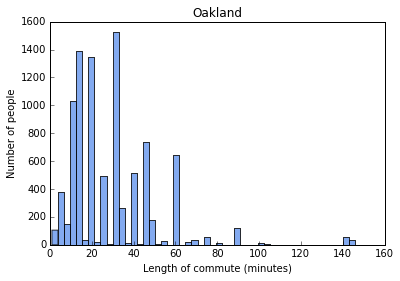

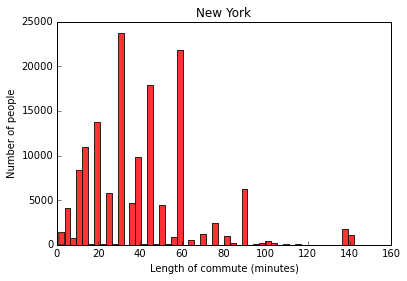

In [143]:
# histogram of travel time to work - NOTE THAT THIS IS UNWEIGHTED
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

numBins = 50
ax.hist(person_emp[(person_emp.trantime != 0) & (person_emp.city == "Oakland")][['trantime']].as_matrix(), \
        numBins, alpha=0.8, color = 'cornflowerblue')
ax.tick_params(right = "off")
ax.tick_params(top = "off")
ax.set_xlabel('Length of commute (minutes)')
ax.set_ylabel('Number of people')
ax.set_title('Oakland')
plt.show()

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)

numBins = 50
ax.hist(person_emp[(person_emp.trantime != 0) & (person_emp.city == "New York")][['trantime']].as_matrix(), \
        numBins, alpha=0.8, color = 'red')
ax.tick_params(right = "off")
ax.tick_params(top = "off")
ax.set_xlabel('Length of commute (minutes)')
ax.set_ylabel('Number of people')
ax.set_title('New York')
plt.show()


In [144]:
# Type of transportation used to get to work (using person-weights)
weightedT = wtd_prop(person_emp, 'tranwork')
# Percent not proportion
weightedT['New York'] = weightedT['New York'] * 100
weightedT['Oakland'] = weightedT['Oakland'] * 100

print weightedT

city       New York    Oakland
tranwork                      
0          2.323771   3.283316
10        26.210846  63.234784
20         0.066586   0.311494
31        11.391420   7.543208
32         0.263647   0.244144
33        41.621221  10.136681
34         1.578094   0.369435
35         0.966757   0.080226
36         0.236852   0.150052
40         0.943412   2.693508
50         9.817891   4.295548
60         0.605812   1.435646
70         3.973691   6.221958


In [145]:
# renaming rows and columns for nice graphing
weightedT = weightedT.rename(index={0: 'NA', 10: 'Auto, truck, or van', 20: 'Motorcycle', \
                      31: 'Bus or trolley bus', 32: 'Streetcar or trolley car', \
                      33: 'Subway or elevated', 34: 'Railroad', 35: 'Taxicab', \
                      36: 'Ferryboat', 40: 'Bicycle', 50: 'Walked only', \
                      60: 'Other', 70: 'Worked at home'})
print weightedT

city                       New York    Oakland
tranwork                                      
NA                         2.323771   3.283316
Auto, truck, or van       26.210846  63.234784
Motorcycle                 0.066586   0.311494
Bus or trolley bus        11.391420   7.543208
Streetcar or trolley car   0.263647   0.244144
Subway or elevated        41.621221  10.136681
Railroad                   1.578094   0.369435
Taxicab                    0.966757   0.080226
Ferryboat                  0.236852   0.150052
Bicycle                    0.943412   2.693508
Walked only                9.817891   4.295548
Other                      0.605812   1.435646
Worked at home             3.973691   6.221958


In [146]:
dfList = weightedT['New York'].tolist()
print dfList

[2.3237710743741631, 26.210845942421006, 0.066586151118138939, 11.391419698709987, 0.26364691856827582, 41.621221034894567, 1.5780943754286469, 0.96675724665876028, 0.2368516345382651, 0.94341188787172292, 9.8178906378885831, 0.6058120605236208, 3.9736913370042615]


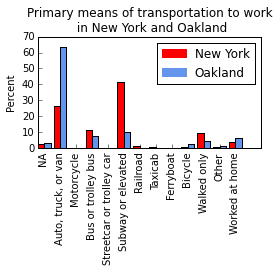

In [147]:
# graphing the modes of commute
N = 13
ind = np.arange(N)  # the x locations for the groups
width = 0.4      # the width of the bars

fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)

rects1 = ax.bar(ind, weightedT['New York'].tolist(), width, color = 'red')
rects2 = ax.bar(ind+width, weightedT['Oakland'].tolist(), width, color = 'cornflowerblue')
ax.tick_params(right="off")
ax.tick_params(top="off")
ax.set_ylabel('Percent')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('NA', 'Auto, truck, or van', 'Motorcycle', 'Bus or trolley bus', 'Streetcar or trolley car', \
                    'Subway or elevated', 'Railroad', 'Taxicab', 'Ferryboat', 'Bicycle', 'Walked only', 'Other', \
                    'Worked at home') )

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)

nyc_leg = mpatches.Patch(color='red', label='New York')
oak_leg = mpatches.Patch(color='cornflowerblue', label='Oakland')
ax.legend(handles=[nyc_leg, oak_leg])

ax.set_title('Primary means of transportation to work \n in New York and Oakland')

plt.savefig('/Users/laura/Dropbox/datamatters/fig1.png', bbox_inches='tight', dpi = 150)

In [149]:
# what about the unemployed?
employment = pd.read_csv(path_acs_emp)
employment.head() # quick look at the data

,year,datanum,serial,hhwt,city,gq,pernum,perwt,repwtp,nchild,...,repwtp71,repwtp72,repwtp73,repwtp74,repwtp75,repwtp76,repwtp77,repwtp78,repwtp79,repwtp80
0,2014,5,327896,1100,4930,1,1,1200,1,0,...,5,4,15,10,16,21,3,9,11,4
1,2014,5,327903,1200,4930,1,1,1200,1,1,...,12,3,10,3,20,20,12,11,12,21
2,2014,5,327903,1200,4930,1,2,900,1,1,...,9,3,10,2,13,14,9,8,7,9
3,2014,5,327903,1200,4930,1,3,1700,1,0,...,21,4,17,6,27,31,17,16,14,24
4,2014,5,327919,1400,4930,1,1,1400,1,2,...,16,3,4,28,21,4,16,27,4,13


In [150]:
# just keeping the people who are non-student unemployed 
unemp = employment.loc[(person["empstat"] == 2)]
unemp = unemp.loc[(unemp["gradeatt"] == 0)]
unemp.head()

# again renaming city var as Oakland and NYC
unemp["city"].replace({4610: "New York", 4930: "Oakland"}, inplace = True)

In [151]:
# About the unemployed - proportion without health insurance
unemp["hcovany"].replace(1, 0, inplace = True)
unemp["hcovany"].replace(2, 1, inplace = True)
print wtd_prop(unemp, 'hcovany') # 1-no, no health insurance

city     New York   Oakland
hcovany                    
0        0.322653  0.405933
1        0.677347  0.594067


In [152]:
# Is the difference in health insurance coverage between Oakland and NYC statistically significant?
# Using replicate weights to ge the correct standard errors
# Creating iterable list of replicate weights
hwt = 'repwtp'
hwts = [hwt+str(inum) for inum in range(1, 81)] # ['repwt1', ..., 'repwt80']

# saving Oakland and NYC means
props = wtd_prop(unemp, 'hcovany')

nyc_mean = props.iloc[1]['New York']
oak_mean = props.iloc[1]['Oakland']

print nyc_mean
print oak_mean

0.67734674075
0.59406709715


In [153]:
# variance of the point estimate x_0 where x_i are the replicate weight estimates 
# variance(x_0) = (4/80) * sum(x_i - x_0)^2 (square root to get standard error)
nyc_se = []
oak_se = []

nyc = unemp[unemp["city"] == "New York"]
oak = unemp[unemp["city"] == "Oakland"]

for weight in hwts:
    nyc_se.append(float((np.average(nyc["hcovany"], weights = nyc[weight]) - nyc_mean) ** 2))
nyc_se = (np.sum(nyc_se) * .05) ** .5    
for weight in hwts:
    oak_se.append(float((np.average(oak["hcovany"], weights = oak[weight]) - oak_mean) ** 2))
oak_se = (np.sum(oak_se) * .05) ** .5
    
print "Standard error for proportion without health insurance in New York is " + str(nyc_se)
print "Standard error for proportion without health insurance in Oakland is " + str(oak_se)

Standard error for proportion without health insurance in New York is 0.00504878969964
Standard error for proportion without health insurance in Oakland is 0.0188740114305


In [155]:
# Point estimate and confidence interval for proportion with health insurance
print "Percent of unemployed without health insurance, New York = " + str(round(nyc_mean * 100, 1)) + \
    "% (CI = " + str(round(((nyc_mean - (1.96*nyc_se)) * 100), 1)) + "% , " + \
    str(round(((nyc_mean + (1.96*nyc_se)) * 100), 1)) + "%)"
print "Percent of unemployed without health insurance, Oakland = " + str(round(oak_mean * 100, 1)) + \
    "% (CI = " + str(round(((oak_mean - (1.96*oak_se)) * 100), 1)) + "% , " + \
    str(round(((oak_mean + (1.96*oak_se)) * 100), 1)) + "%)"

Percent of unemployed without health insurance, New York = 67.7% (CI = 66.7% , 68.7%)
Percent of unemployed without health insurance, Oakland = 59.4% (CI = 55.7% , 63.1%)


In [156]:
# Graphing
forgraph = pd.DataFrame({'New York' : pd.Series([nyc_mean*100, (1.96*nyc_se) * 100], index=['mean', 'se']), 
                           'Oakland' : pd.Series([oak_mean*100, (1.96*oak_se) * 100], index=['mean', 'se'])})
print forgraph

       New York    Oakland
mean  67.734674  59.406710
se     0.989563   3.699306


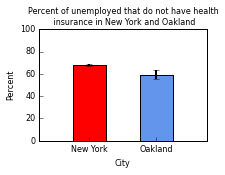

In [157]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)

ind = np.arange(2)
width = 0.5

rects1 = ax.bar(1, forgraph.iloc[0,0], width,
                color='red', yerr = forgraph.iloc[1,0],
                error_kw=dict(elinewidth=2,ecolor='black'))

rects1 = ax.bar(2, forgraph.iloc[0,1], width,
                color='cornflowerblue', yerr = forgraph.iloc[1,1],
                error_kw=dict(elinewidth=2,ecolor='black'))
ax.tick_params(right="off")
ax.tick_params(top="off")
ax.set_xlim(.5,3)
ax.set_xticks([1.25, 2.25])
ax.axes.set_ylim([0,100])
xTickMarks = ["New York", "Oakland"]
xtickNames = ax.set_xticklabels(xTickMarks)
ax.set_ylabel('Percent')
ax.set_xlabel('City')
ax.set_title('Percent of unemployed that do not have health\n insurance in New York and Oakland')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(8)

plt.savefig('/Users/laura/Dropbox/datamatters/fig2.png', bbox_inches='tight', dpi = 200)

In [158]:
# average number of children in the household
grouped = unemp.groupby('city')
minifun = lambda x: np.average(x.nchild, weights = x.perwt)
print grouped.apply(minifun)

city
New York    0.610400
Oakland     0.673011
dtype: float64


In [159]:
# Level of education
educstat = wtd_prop(unemp, 'educ')
# renaming for easy reading
educstat = educstat.rename(index={0: 'NA or no schooling', 1: 'Nursery school to grade 4', 2: 'Grade 5, 6, 7, or 8', \
                      3: 'Grade 9', 4: 'Grade 10', \
                      5: 'Grade 11', 6: 'Grade 12', 7: '1 year of college', \
                      8: '2 years of college', 10: '4 years of college', 11: '5+ years of college'})
print educstat
# half have completed either high school or one year of college
print 0.383328 + 0.134797 
print 0.340001 + 0.171239

city                       New York   Oakland
educ                                         
NA or no schooling         0.021641  0.026120
Nursery school to grade 4  0.008347  0.015148
Grade 5, 6, 7, or 8        0.048234  0.057921
Grade 9                    0.024032  0.022916
Grade 10                   0.032762  0.026751
Grade 11                   0.049573  0.047094
Grade 12                   0.383328  0.340001
1 year of college          0.134797  0.171239
2 years of college         0.060965  0.061368
4 years of college         0.168593  0.163762
5+ years of college        0.067730  0.067680
0.518125
0.51124
